# Nigerian Fraud EDA and Preprocessing

## 1 Import libraries

Import the required libraries for data manipulation, email and HTML parsing, text cleaning, and data visualisations.

In [8]:
print("Loading libraries...")

# Core libraries
import os
import pandas as pd
import numpy as np
import re # For regular expressions
import time # To time operations

import kagglehub

# Email parsing (might be needed if emails are in raw format)
import email
from email import policy
from email.parser import BytesParser, Parser
from email.utils import parsedate_to_datetime, getaddresses

# HTML processing (if applicable)
from bs4 import BeautifulSoup

# Text processing
import unicodedata

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', 50)

print("Libraries imported.\n")

Loading libraries...
Libraries imported.



## 2 Load raw Nigerian Fraud data

Using the `kagglehub` library to download the "Fraudulent E-mail Corpus" (`rtatman/fraudulent-email-corpus`).
This dataset is described as a collection of "Nigerian" Fraud Letters contained within a single text file.
Our first step will be to download this file, read its content, and then split the content into individual email messages for parsing.

In [9]:
# This will be the path to the single text file containing all fraud emails
FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH = None

try:
    print("Downloading/accessing 'rtatman/fraudulent-email-corpus' via kagglehub...")
    fraud_dataset_base_path = kagglehub.dataset_download("rtatman/fraudulent-email-corpus")
    print(f"Dataset downloaded/cached by kagglehub at: {fraud_dataset_base_path}")

    # --- List contents of the downloaded path to find the data file ---
    print(f"\n--- Contents of '{fraud_dataset_base_path}': ---")
    found_text_file = False

    if os.path.exists(fraud_dataset_base_path) and os.path.isdir(fraud_dataset_base_path):

        for item in os.listdir(fraud_dataset_base_path):
            print(item)

            # The Kaggle dataset page for "rtatman/fraudulent-email-corpus"
            # typically has one primary text file. We need to identify its name.
            # It's often named something like 'fradulent_emails.txt', 'corpus.txt', etc.
            # Or it might be the only .txt file.

            if item.lower().endswith('.txt'): # A common assumption for such files
                FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH = os.path.join(fraud_dataset_base_path, item)
                print(f"Identified potential data file: {FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH}")
                found_text_file = True
                break # Assuming there's only one main text file. If multiple, adjust logic.

        if not found_text_file:
            print(f"ERROR: No .txt file found directly in '{fraud_dataset_base_path}'.")
            print("Please inspect the contents manually and update the logic to find the correct data file.")

    else:
        print(f"ERROR: The path '{fraud_dataset_base_path}' reported by kagglehub does not exist or is not a directory.")

    print("--- End of directory contents ---\n")

    if FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH and os.path.exists(FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH):
        print(f"Successfully located the fraud corpus text file: {FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH}")
        # We won't load the full content into a DataFrame here yet,
        # just confirm we can access it.
        # The next step will be to read and split this file.
    elif FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH is None and found_text_file is False:
         print("Could not automatically identify the .txt data file in the downloaded dataset.")

    else:
        print(f"ERROR: Identified path {FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH} does not seem to exist.")


except Exception as e:
    print(f"An error occurred during dataset download or path setup: {e}")
    print("Ensure kagglehub is installed and Kaggle API credentials configured if needed.")

Downloading/accessing 'rtatman/fraudulent-email-corpus' via kagglehub...
Dataset downloaded/cached by kagglehub at: /root/.cache/kagglehub/datasets/rtatman/fraudulent-email-corpus/versions/1

--- Contents of '/root/.cache/kagglehub/datasets/rtatman/fraudulent-email-corpus/versions/1': ---
fradulent_emails.txt
Identified potential data file: /root/.cache/kagglehub/datasets/rtatman/fraudulent-email-corpus/versions/1/fradulent_emails.txt
--- End of directory contents ---

Successfully located the fraud corpus text file: /root/.cache/kagglehub/datasets/rtatman/fraudulent-email-corpus/versions/1/fradulent_emails.txt


## 3 Read and split single text files into individual emails

In [10]:
# Initialise
all_fraud_email_strings = []

if FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH and os.path.exists(FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH):
    print(f"Reading content from: {FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH}")

    try:
        with open(FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH, 'r', encoding='latin-1', errors='ignore') as f:
            full_text_content = f.read()

        print(f"Successfully read {len(full_text_content)} characters.")

        # Splitting logic (using the 'From ' heuristic as a starting point)
        # You MUST inspect your actual text file to see if this is the correct delimiter.
        # It's common for mbox-style concatenated email files.
        raw_messages_split = full_text_content.split('\nFrom ') # Split by newline then "From "

        if len(raw_messages_split) > 1:
            # The first element might not start with "From " if the file doesn't begin with it.
            # The subsequent elements need "From " prepended.
            all_fraud_email_strings.append(raw_messages_split[0]) # Add the first part as is

            for i in range(1, len(raw_messages_split)):
                all_fraud_email_strings.append("From " + raw_messages_split[i]) # Add back "From "

            # If the very first element was not actually an email (e.g. some file header)
            # and does not start with "From ", you might want to remove it after inspection.
            # For now, we keep it.
            print(f"Split into approximately {len(all_fraud_email_strings)} email strings based on '\\nFrom ' delimiter.")

            if all_fraud_email_strings:
                print(f"First few chars of first extracted string: {all_fraud_email_strings[0][:300]}")

                if len(all_fraud_email_strings) > 1:
                     print(f"First few chars of second extracted string: {all_fraud_email_strings[1][:300]}")

        elif full_text_content.strip(): # If split didn't work, treat as one message (unlikely for this dataset)
            all_fraud_email_strings = [full_text_content]
            print("Warning: Could not split by '\\nFrom '. Treating entire file as one message string (or split failed).")

        else:
            print("File was empty or split resulted in no messages.")

    except Exception as e:
        print(f"Error reading or splitting the fraud corpus file: {e}")

else:
    print("FRAUD_CORPUS_SINGLE_TEXT_FILE_PATH is not set or file does not exist. Cannot read and split.")

Reading content from: /root/.cache/kagglehub/datasets/rtatman/fraudulent-email-corpus/versions/1/fradulent_emails.txt
Successfully read 17344435 characters.
Split into approximately 3978 email strings based on '\nFrom ' delimiter.
First few chars of first extracted string: From r  Wed Oct 30 21:41:56 2002
Return-Path: <james_ngola2002@maktoob.com>
X-Sieve: cmu-sieve 2.0
Return-Path: <james_ngola2002@maktoob.com>
Message-Id: <200210310241.g9V2fNm6028281@cs.CU>
From: "MR. JAMES NGOLA." <james_ngola2002@maktoob.com>
Reply-To: james_ngola2002@maktoob.com
To: webmaster@acl
First few chars of second extracted string: From r  Thu Oct 31 08:11:39 2002
Return-Path: <bensul2004nng@spinfinder.com>
X-Sieve: cmu-sieve 2.0
Return-Path: <bensul2004nng@spinfinder.com>
Message-Id: <200210311310.g9VDANt24674@bloodwork.mr.itd.UM>
From: "Mr. Ben Suleman" <bensul2004nng@spinfinder.com>
Date: Thu, 31 Oct 2002 05:10:00
To: R@M
S


## 4 Define preprocessing

Key aspects for this dataset:

- Parse individual email strings from the `all_fraud_email_strings` list.
- Apply **minimal cleaning** to the body and subject to preserve social engineering cues, as per the original thesis plan for this specific dataset.

In [11]:
def get_email_body_and_urls(message_obj):
    """
    Extracts text body and URLs from an email.Message object.
    Tries plain text first, then HTML. Extracts hrefs from  tags in HTML.
    """

    body_text = ""
    html_body_text = ""
    urls_in_html = []

    if message_obj is None: return "", []

    if message_obj.is_multipart():

        for part in message_obj.walk():
            content_type = part.get_content_type(); content_disposition = str(part.get_content_disposition())

            if "attachment" not in content_disposition:

                if content_type == "text/plain" and not body_text:

                    try:
                      payload = part.get_payload(decode=True); charset = part.get_content_charset() or 'utf-8'; body_text = payload.decode(charset, errors='replace')

                    except Exception: pass

                elif content_type == "text/html" and not html_body_text:

                    try:
                        payload = part.get_payload(decode=True); charset = part.get_content_charset() or 'utf-8'; html_content = payload.decode(charset, errors='replace'); html_body_text = html_content
                        soup_part = BeautifulSoup(html_content, 'html.parser')
                        for link_tag in soup_part.find_all('a', href=True): urls_in_html.append(link_tag['href'])

                    except Exception: pass

    # Not multipart
    else:
        content_type = message_obj.get_content_type()

        try:
            payload = message_obj.get_payload(decode=True)
            charset = message_obj.get_content_charset() or 'utf-8'

            if content_type == "text/plain":
              body_text = payload.decode(charset, errors='replace')

            elif content_type == "text/html":
                html_body_text = payload.decode(charset, errors='replace')
                soup_part = BeautifulSoup(html_body_text, 'html.parser')

                for link_tag in soup_part.find_all('a', href=True):
                  urls_in_html.append(link_tag['href'])

        except Exception: pass

    # Logic to decide final body: prefer plain. If not, clean HTML.
    final_body = ""
    if body_text.strip():
      final_body = body_text

    elif html_body_text.strip():
        soup = BeautifulSoup(html_body_text, 'html.parser')

        # Extract text, trying to preserve some structure with spaces
        # Remove script and style elements
        for script_or_style in soup(["script", "style"]):
          script_or_style.decompose()

        final_body = soup.get_text(separator=' ', strip=True)

    # Unique URLs
    return final_body, list(set(urls_in_html))

In [12]:
def clean_text_content_minimal(text):
  if not isinstance(text, str):
    return ""

  # NFKC normalization is generally safe and good for consistency
  text = unicodedata.normalize('NFKC', text)

  # Lowercasing can be debated for preserving emphasis, but often done for consistency
  text = text.lower()

  # Replace multiple whitespaces with a single space
  text = re.sub(r'\s+', ' ', text)

  # For Nigerian fraud, we want to be *less* aggressive with removing punctuation or special characters
  # as they might be part of the "style" or contain pseudo-official looking marks.
  # We might still remove non-ASCII if they are causing encoding issues and not part of the message intent.
  # text = re.sub(r'[^\x00-\x7F]+', ' ', text) # Optional: remove non-ASCII
  # Avoid aggressive removal of punctuation that might be used for emphasis or specific phrasing.

  # For now, just strip leading/trailing whitespace.
  text = text.strip()

  return text

In [13]:
def extract_email_headers(message_obj):
    headers = {}

    if message_obj is None:
      return {'subject': '',
              'from_address': '',
              'to_address': '',
              'date_time': pd.NaT,
              'message_id': ''
      }

    try:
        # Ensure it's a string
        headers['subject'] = str(message_obj.get('Subject', ''))

        from_addrs = getaddresses(message_obj.get_all('From', []))
        headers['from_address'] = ', '.join([addr for name, addr in from_addrs if addr])

        to_addrs = getaddresses(message_obj.get_all('To', []))
        headers['to_address'] = ', '.join([addr for name, addr in to_addrs if addr])

        date_str = message_obj.get('Date', '')
        headers['date_time'] = pd.to_datetime(parsedate_to_datetime(date_str), errors='coerce') if date_str else pd.NaT

        headers['message_id'] = str(message_obj.get('Message-ID', ''))

    except Exception:
      headers.setdefault('subject', '')
      headers.setdefault('from_address', '')
      headers.setdefault('to_address', '')
      headers.setdefault('date_time', pd.NaT)
      headers.setdefault('message_id', '')

    return headers

In [14]:
def parse_fraud_email_string(email_raw_string, original_identifier="N/A"):
    """Parses an email from its raw string content, applying minimal cleaning."""

    if not isinstance(email_raw_string, str) or not email_raw_string.strip():
        print(f"Warning: Empty or invalid email string for {original_identifier}")
        return None

    try:
        # Use email.parser.Parser for string inputs
        message_obj = Parser(policy=policy.default).parsestr(email_raw_string)

    except Exception as e:
        print(f"Warning: Could not parse email string for {original_identifier}: {e}")
        return None

    if message_obj is None:
        return None

    headers = extract_email_headers(message_obj)
    body_content, urls = get_email_body_and_urls(message_obj) # body_content is relatively raw here

    return {
        'original_identifier': original_identifier,
        'message_id': headers['message_id'],
        'date_time': headers['date_time'],
        'from_address': headers['from_address'],
        'to_address': headers['to_address'],
        'subject_original': headers['subject'], # Keep original for inspection
        'subject_cleaned_minimal': clean_text_content_minimal(headers['subject']),
        'body_cleaned_minimal': clean_text_content_minimal(body_content), # Apply minimal cleaning
        'urls_in_email': urls,
        'body_length': len(body_content), # Length of body before minimal cleaning
        'num_urls': len(urls)
    }

## 5 Apply preprocessing

Loop through the `all_fraud_email_strings`, parse each one,
and collect the structured data.

In [15]:
df_processed_nigerian_fraud = pd.DataFrame()
processed_fraud_emails_list = []

# Ensure all_fraud_email_strings is defined and populated from Section 2.1
if 'all_fraud_email_strings' in globals() and all_fraud_email_strings:
    print(f"Applying parsing and minimal cleaning to {len(all_fraud_email_strings)} fraud email strings...")
    start_time = time.time()

    for i, email_str_content in enumerate(all_fraud_email_strings):

        # Using index as an identifier for now, or use Message-ID if reliably parsed
        parsed_data = parse_fraud_email_string(email_str_content, original_identifier=f"fraud_email_{i+1}")

        if parsed_data:
            processed_fraud_emails_list.append(parsed_data)

        # Progress every 10%
        if (i + 1) % (max(1, len(all_fraud_email_strings) // 10)) == 0:
            print(f"  Processed {i + 1}/{len(all_fraud_email_strings)} email strings...")

    df_processed_nigerian_fraud = pd.DataFrame(processed_fraud_emails_list)
    end_time = time.time()

    if not df_processed_nigerian_fraud.empty:
        print(f"\nSuccessfully processed {len(df_processed_nigerian_fraud)} Nigerian Fraud emails in {end_time - start_time:.2f} seconds.")
        print("Processed Nigerian Fraud head:")
        print(df_processed_nigerian_fraud.head())
        print("\nProcessed Nigerian Fraud info:")
        df_processed_nigerian_fraud.info()

    else:
        print("No Nigerian Fraud emails were successfully processed. Check the input strings or parsing logic.")

else:
    print("Variable 'all_fraud_email_strings' not found or is empty.")

Applying parsing and minimal cleaning to 3978 fraud email strings...
  Processed 397/3978 email strings...
  Processed 794/3978 email strings...
  Processed 1191/3978 email strings...
  Processed 1588/3978 email strings...
  Processed 1985/3978 email strings...
  Processed 2382/3978 email strings...
  Processed 2779/3978 email strings...
  Processed 3176/3978 email strings...
  Processed 3573/3978 email strings...
  Processed 3970/3978 email strings...

Successfully processed 3978 Nigerian Fraud emails in 12.59 seconds.
Processed Nigerian Fraud head:
  original_identifier                                          message_id  \
0       fraud_email_1                 <200210310241.g9V2fNm6028281@cs.CU>   
1       fraud_email_2     <200210311310.g9VDANt24674@bloodwork.mr.itd.UM>   
2       fraud_email_3       <200210312227.g9VMQvDj017948@bluewhale.cs.CU>   
3       fraud_email_4       <200210312253.g9VMreDj018024@bluewhale.cs.CU>   
4       fraud_email_5  <200211010948.gA19mLu22932@perfectw

## 6 Intial EDA on processed data

Explore the structure and content of the parsed Nigerian Fraud dataset.

In [16]:
if not df_processed_nigerian_fraud.empty:
    print("--- Nigerian Fraud Data Info ---")
    df_processed_nigerian_fraud.info(show_counts=True)
    print(f"\nMissing values in processed data:\n{df_processed_nigerian_fraud.isnull().sum()}")
    print("\n--- Example Email Content (Minimally Cleaned, first 300 chars) ---")

    for content in df_processed_nigerian_fraud['body_cleaned_minimal'].sample(min(3, len(df_processed_nigerian_fraud))):
        # Print first 300 chars
        print(content[:300])
        print("-" * 30)

else:
    print("Processed Nigerian Fraud DataFrame is empty. Skipping EDA.")

--- Nigerian Fraud Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3978 entries, 0 to 3977
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   original_identifier      3978 non-null   object
 1   message_id               3978 non-null   object
 2   date_time                3421 non-null   object
 3   from_address             3978 non-null   object
 4   to_address               3978 non-null   object
 5   subject_original         3978 non-null   object
 6   subject_cleaned_minimal  3978 non-null   object
 7   body_cleaned_minimal     3978 non-null   object
 8   urls_in_email            3978 non-null   object
 9   body_length              3978 non-null   int64 
 10  num_urls                 3978 non-null   int64 
dtypes: int64(2), object(9)
memory usage: 342.0+ KB

Missing values in processed data:
original_identifier          0
message_id                   0
date_time             

## 7 Labelling strategy

All emails in this "Fraudulent E-mail Corpus" (Nigerian Fraud) are considered phishing/scams.
Assign label `1`.

In [17]:
if not df_processed_nigerian_fraud.empty:
    # 1 for phishing/fraud
    df_processed_nigerian_fraud['label'] = 1
    print("Added 'label' column (all 1s for phishing/fraud).")
    print(df_processed_nigerian_fraud[['body_cleaned_minimal', 'label']].head())

else:
    print("Processed Nigerian Fraud DataFrame is empty. Skipping labeling.")

Added 'label' column (all 1s for phishing/fraud).
                                                                                                                                    body_cleaned_minimal  \
0  from:mr. james ngola. confidential tel: 233-27-587908. e-mail: (james_ngola2002@maktoob.com). urgent business assistance and partnership. dear fri...   
1  dear friend, i am mr. ben suleman a custom officer and work as assistant controller of the customs and excise department of the federal ministry o...   
2  from his royal majesty (hrm) crown ruler of eleme kingdom chief daniel eleme, phd, eze 1 of eleme.e-mail address:obong_715@epatra.com attention:pr...   
3  from his royal majesty (hrm) crown ruler of eleme kingdom chief daniel eleme, phd, eze 1 of eleme.e-mail address:obong_715@epatra.com attention:pr...   
4  dear sir, it is with a heart full of hope that i write to seek your help in respect of the context below. i am mrs. maryam abacha the former first...   

   label  
0 

## 8 Further EDA on labeled and processed data

--- Basic Stats of Processed Nigerian Fraud Data ---
         body_length  body_cleaned_length     num_urls
count    3978.000000          3978.000000  3978.000000
mean     2605.638260          2566.629462     0.186777
std      2341.538559          2303.701543     0.624338
min         0.000000             0.000000     0.000000
25%      1866.000000          1829.250000     0.000000
50%      2544.000000          2494.500000     0.000000
75%      3211.750000          3172.000000     0.000000
max    124968.000000        122659.000000     7.000000


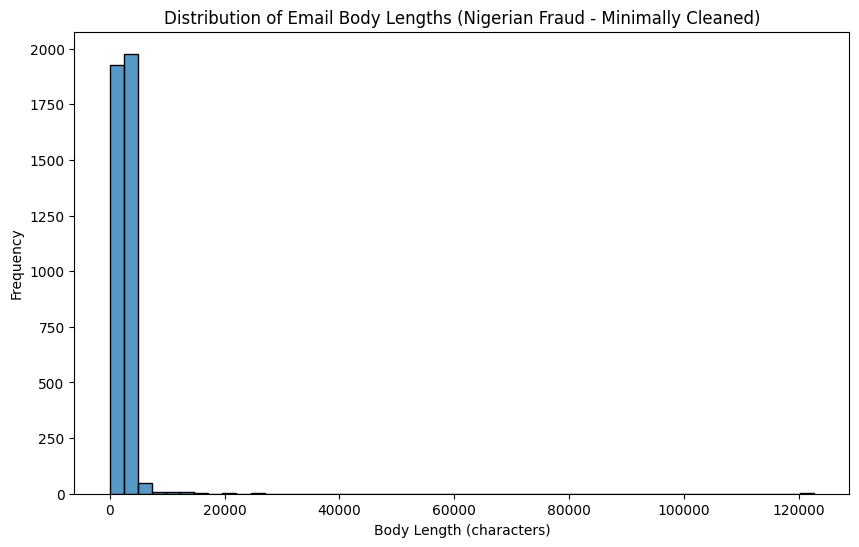


--- Sample Subjects (Minimally Cleaned) ---
assistance please
swift response plz.
from:mrs.amina.a bello.
acknowledge my mail
mail me


In [18]:
if not df_processed_nigerian_fraud.empty:
    print("--- Basic Stats of Processed Nigerian Fraud Data ---")

    # 'body_length' was from original body, let's add length of minimally cleaned body
    df_processed_nigerian_fraud['body_cleaned_length'] = df_processed_nigerian_fraud['body_cleaned_minimal'].apply(len)
    print(df_processed_nigerian_fraud[['body_length', 'body_cleaned_length', 'num_urls']].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df_processed_nigerian_fraud['body_cleaned_length'], bins=50, kde=False)
    plt.title('Distribution of Email Body Lengths (Nigerian Fraud - Minimally Cleaned)')
    plt.xlabel('Body Length (characters)')
    plt.ylabel('Frequency')
    plt.show()

    print("\n--- Sample Subjects (Minimally Cleaned) ---")

    for text in df_processed_nigerian_fraud['subject_cleaned_minimal'].sample(min(5, len(df_processed_nigerian_fraud))):
        print(text[:150]) # Print first 150 chars of subject

else:
    print("Processed Nigerian Fraud DataFrame is empty. Skipping further EDA.")

## 9 Save processed data

Save the processed Nigerian Fraud data. This will serve as a specialized test set.

In [19]:
if not df_processed_nigerian_fraud.empty:
    OUTPUT_FILENAME_NIGERIAN = f'nigerian_fraud_test_processed_{len(df_processed_nigerian_fraud)}.csv'
    # Saves to /content/ in Colab if just filename is given

    try:
        df_processed_nigerian_fraud.to_csv(OUTPUT_FILENAME_NIGERIAN, index=False)
        print(f"Processed Nigerian Fraud test data saved to Colab runtime at: /content/{OUTPUT_FILENAME_NIGERIAN}")

    except Exception as e:
        print(f"Error saving processed Nigerian Fraud data: {e}")

else:
    print("Processed Nigerian Fraud DataFrame is empty. Nothing to save.")

Processed Nigerian Fraud test data saved to Colab runtime at: /content/nigerian_fraud_test_processed_3978.csv
IMPORTANT: This file is temporary. Download it or save to Google Drive to keep it.
